In [1]:
import os
import json
import pandas
import csv
import pycountry

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

In [2]:
DATA_ROOT = "../data/"

In [3]:
# Read the category names
def get_raw_list(file_path):
    paths = []
    with open(file_path, 'r') as f:
        paths = f.readlines()
    return paths

# Change the country_code to name of country if possible
def get_country_name(country_code):
    country_class = pycountry.countries.get(alpha_2=country_code)
    try:
        if country_code == 'TW':
            country_name = 'Taiwan'
        else:
            country_name = country_class.name
    except:
        country_name = country_code
    return country_name

# Get drawing from ndjson file
def get_drawings_dict(d_key):
    filename = "../data/simplified_" + d_key + ".ndjson"
    
    by_key_id = {}
    with open(filename) as f:
        for line in f:
            drawing = json.loads(line)
            
            # Change the country code to country name
            country_name = get_country_name(drawing['countrycode'])
            drawing['countrycode'] = country_name
            
            # Filter only recognised one
            if drawing['recognized'] == True:
                by_key_id[drawing['key_id']] = drawing
                
    return by_key_id

# Get the x and y coordinates of the drawing 
def get_coordinates(drawing):
    x = []
    y = []
    list_stroke = drawing['drawing']
    for i in range(len(list_stroke)):
        x.append(list_stroke[i][0])
        y.append(list_stroke[i][1])
    return x,y

# Get the set of country
def get_country(drawing_dict):
    country_set = set(val['countrycode'] for val in drawing_dict.values())
    return country_set

# Get all sample from a country
def get_keys_from_country(country, drawing_dict):
    key_list = []
    for (key,value) in drawing_dict.items():
        if value['countrycode'] == country:
            key_list.append(key)
    return key_list

# Save the print
def save_figure(list_key, drawing_dict):
    fig, ax = plt.subplots(figsize=(5, 5),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
    fig.tight_layout()
    
    # Create color map
    cmap = plt.get_cmap('nipy_spectral')
    colors = [cmap(i) for i in np.linspace(0, 1, 10)]

    for i,key in enumerate(list_key[:10]):
        x,y = get_coordinates(drawing_dict[key])
        for j in range(len(x)):
            plt.plot(x[j],y[j],color = colors[i], linewidth=1)
    plt.savefig('test.png')
    
# Save the print
def save_figure_animated(list_key, drawing_dict):
    fig, ax = plt.subplots(figsize=(3, 3),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
    fig.tight_layout
    
    plt.xlim(0, 255)
    plt.ylim(0, 255)
        
    # Create color map
    cmap = plt.get_cmap('nipy_spectral')
    colors = [cmap(i) for i in np.linspace(0, 1, 10)]
    
    x_list = []
    y_list = []
    lines = []
    max_len = 0
    for i,key in enumerate(list_key[:10]):
        x,y = get_coordinates(drawing_dict[key])
        temp_x = []
        temp_y = []
        for j in range(len(x)):
            x_list.append(x[j])
            y_list.append(y[j])
            line = plt.plot([], [])[0]
            line.set_color(colors[i])
            line.set_linewidth(0.8)
            lines.append(line)
            
            # Get maximum length for the frames
            if (len(x[j]) > max_len):
                max_len = len(x[j])
    
    def init():
        #init lines
        for line in lines:
            line.set_data([], [])
        return lines

    def animate(i):
        for j,line in enumerate(lines):
            line.set_data(x_list[j][:i], y_list[j][:i])
        return lines
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=max_len + 5, interval=50, blit=True)
    
    return anim
    

In [4]:
list_category = get_raw_list("../processed_data/list_category_8.txt")

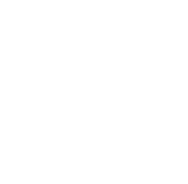

In [5]:
dict1 = get_drawings_dict('power_outlet')
country_set = get_country(dict1)

for country in country_set:
        list_key = get_keys_from_country(country, dict1)

anim = save_figure_animated(list_key, dict1)

In [6]:
from matplotlib import animation, rc
from IPython.display import HTML, Image
rc('animation', html='html5')
anim

In [7]:
anim.save('./animation.gif', writer='imagemagick', fps=15)